# Exploratory data analysis and preprocessing

## Contents<a id='Contents'></a>
* [1 Introduction](#1_Introduction)
* [2 Imports](#2_Imports)
* [3 Load data](#3_Load_data)
    * [3.1 Distribution of feature values](#3.1_Distribution_of_feature_values)
    * [3.2 Cleaning feature values](#3.2_Cleaning_feature_values)
    * [3.3 Save data](#3.3_Save_data)
* [4 Summary](#4_Summary)

## 1 Introduction<a id='1_Introduction'></a>

Using a real dataset from the U.S. Small Business Administration (SBA), this data science project addresses the following questions:
* How can machine learning help in making decisions about whether a loan should be approved or denied by the U.S. SBA? 
* How do the different machine learning algorithms compare in terms of predictive ability, model complexity and computational intensity?
* What are the important data features that affect a model's performance?
* If necessary, what other data should be collected to improve a model's performance and help in accurate decision making?

This notebook consists of the exploratory data analysis and preprocessing of the clean dataset saved at the end of the "StepOne_DataWrangling" notebook.

## 2 Imports<a id='2_Imports'></a>

In [1]:
# Import required libraries and functions
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from scipy.stats import ttest_ind
from scipy.stats import norm
from scipy.stats import chi2_contingency
from scipy.stats import f_oneway
from scipy.stats import mannwhitneyu

## 3 Load data<a id='3_Load_data'></a>

In [2]:
# Load data for exploratory data analysis and preprocessing
dfCA = pd.read_csv('../data_models/SBAnational_CA_clean.csv')
dfCA.head().T

,0,1,2,3,4
LoanNr_ChkDgt,1000506000,1000685001,1000715008,1000746002,1000754002
Name,WEYLAND CORPORATION,ANYWHERE SPORTS PRODUCTIONS,John Dailey,ANGEL,"MCCRANEY, INC."
ApprovalDate,7-Feb-06,25-Mar-97,26-Mar-97,7-Feb-06,28-Feb-97
ApprovalFY,2006,1997,1997,2006,1997
Term,83,84,84,36,300
NoEmp,18,6,2,20,50
NewExist,2,1,1,2,1
CreateJob,5,0,0,20,0
RetainedJob,23,0,0,20,0
UrbanRural,1,0,0,1,0


In [3]:
# Check shape of dataframe
dfCA.shape

(130475, 19)

### 3.1 Distribution of feature values<a id='3.1_Distribution_of_feature_values'></a>

Plot histograms to see the distribution of each of the numeric features. This also helps in checking for any (obvious) outliers that might need further investigation.

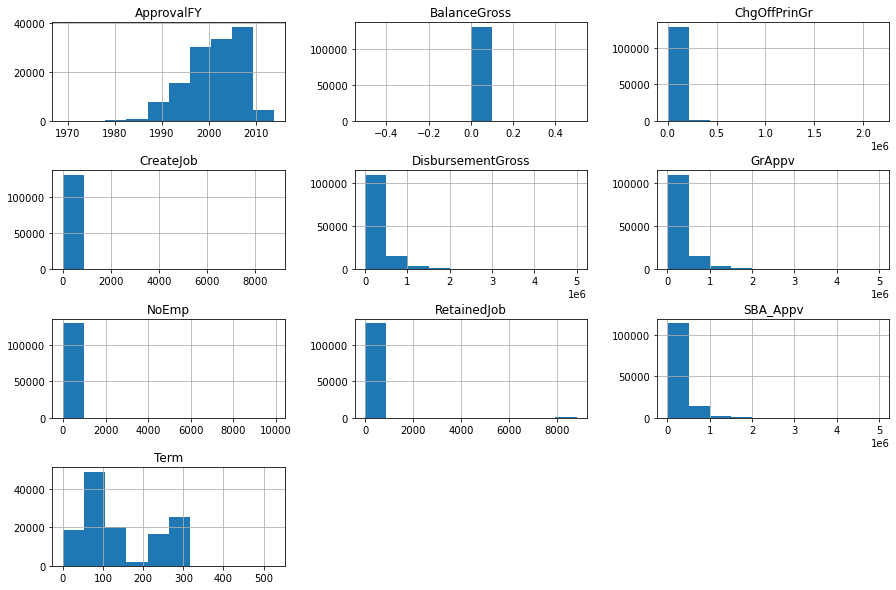

In [5]:
# Plot histograms of each of the numeric features
dfCA.drop(['Default', 'LoanNr_ChkDgt', 'NewExist', 'Sector', 'UrbanRural'],
          axis=1).hist(figsize=(15,10))
plt.subplots_adjust(hspace=0.5);

Apart from the features "ApprovalFY" and "Term", all other features have little to no variance with distributions skewed mostly to the low end. The feature "BalanceGross" seems to have only zero values. The features "ChgOffPrinGr", "CreateJob", "NoEmp", and "RetainedJob" have values mostly near zero with few big outliers. The features "DisbursementGross", "GrAppv", and "SBA_Appv" have very similar distributions with most values clustered near the low end and a few outliers.

### 3.2 Cleaning feature values<a id='3.2_Cleaning_feature_values'></a>
The following section involves cleaning of the feature values, wherever necessary. Each feature is analyzed by plotting a histogram, a boxplot for the default and non-default classes, and a statistical test to see how siginificant is the difference in the distributions of default and non-default classes. The statistical tests also help in getting an overview of the more important and less important features.

For features/variables with Gaussian (or normal) distribution, parametric tests such as Student's T tests and ANOVA tests can help in determining whether two data samples have the same or different distributions. For features that do not have a Gaussian distribution, nonparametric tests such as Mann-Whitney U tests, chi-squared tests, etc., can be used.

**Feature: BalanceGross**

In [6]:
# Display statistical information of the "BalanceGross" feature (Gross amount outstanding)
print(dfCA["BalanceGross"].describe())
dfCA["BalanceGross"].value_counts()

count    130475.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: BalanceGross, dtype: float64


0.0    130475
Name: BalanceGross, dtype: int64

There is no information in this column. Hence, it is removed from the dataframe.

In [7]:
# Remove the "BalanceGross" feature
dfCA = dfCA.drop('BalanceGross', axis=1);

**NOTE:** Logarithmic scaling is a way to scale numeric input features of a dataset, especially if some of the features have skewed distributions. As shown below, features with highly skewed distributions are scaled logarithmically.

**Feature: ChgOffPrinGr**

count    1.304750e+05
mean     1.386899e+04
std      6.843957e+04
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      2.157499e+06
Name: ChgOffPrinGr, dtype: float64


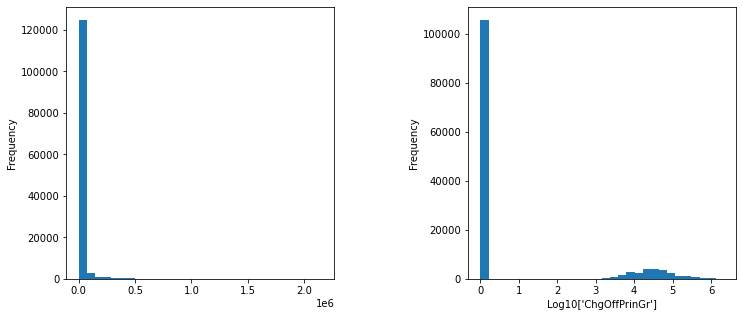

Percentage of zero entries in "ChgOffPrinGr": 80.99%


In [9]:
# Display statistical information of the feature "ChgOffPrinGr" (charged-off amount)
print(dfCA["ChgOffPrinGr"].describe())

# Plot histogram of true vs. log values 
fig, axes = plt.subplots(nrows=1, ncols=2)
plt.rcParams['figure.figsize']=[12,5]
dfCA['ChgOffPrinGr'].plot(kind='hist', bins=30, ax=axes[0])
plt.xlabel('Charged-off amount')
np.log10(dfCA['ChgOffPrinGr']+1).plot(kind='hist', bins=30,
                                      ax=axes[1]).set_xlabel("Log10['ChgOffPrinGr']")
plt.subplots_adjust(wspace=0.5);
plt.show()

# Print percentage of zero entries
print('Percentage of zero entries in "ChgOffPrinGr": ' + 
      str("{:.2f}".format((dfCA['ChgOffPrinGr']==0).mean()*100)) + "%")

Ignoring the large number (about 81%) of zero values in "ChgOffPrinGr", the histogram for the logarithmically-scaled values is not skewed in comparison to the histogram of the original values. The reason for about 81% of zero values in "ChgOffPrinGr" is due to the fact that the dataset has more instances of loans paid in full than of defaulted loans. Hence, the corresponding charged-off amount for the loans paid in full is zero.

,mean,std
Default,,
0,0.000000,0.000000
1,4.473135,0.617426


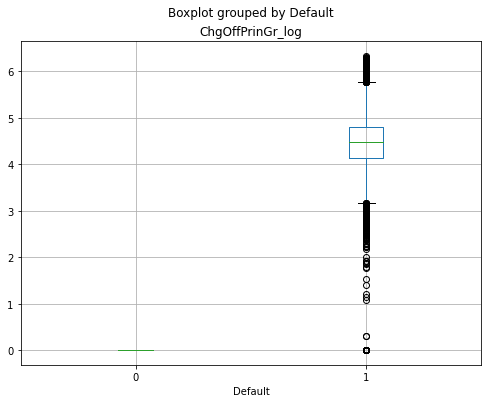

In [11]:
# Boxplot
plt.rcParams['figure.figsize']=[8,6]
dfCA = dfCA.assign(ChgOffPrinGr_log=pd.Series(np.log10(dfCA['ChgOffPrinGr'] + 1)))
dfCA.boxplot(column=['ChgOffPrinGr_log'], by='Default')
pd.DataFrame(dfCA.groupby(['Default'])['ChgOffPrinGr_log'].describe().loc[:,['mean','std']])

The above boxplot displays the distribution of "ChgOffPrinGr" for the non-default (class = 0) and default (class = 1) classes. As expected, the non-default class has no values, and hence no distribution. The distribution for default class has many smaller outliers.

Since the distribution of the logarithmically-scaled values of the feature "ChgOffPrinGr" appears to be similar to a Gaussian distribution, a T-test can be used as a statistical test to see how siginificant is the difference in the distributions of default and non-default classes. A statistical test for this feature is not really necessary since there is no distribution for the non-default class. As shown below, the distributions of non-default and default classes are different.

In [12]:
# Perform a statistical test
a = dfCA[dfCA['Default']==0].ChgOffPrinGr_log
b = dfCA[dfCA['Default']==1].ChgOffPrinGr_log
stat, p = ttest_ind(a, b)
print('stat=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('Same distributions (fail to reject H0)')
else:
    print('Different distributions (reject H0)')

stat=-2354.069, p=0.000
Different distributions (reject H0)


**Feature: CreateJob**

count    130475.000000
mean          7.724928
std         215.715439
min           0.000000
25%           0.000000
50%           0.000000
75%           2.000000
max        8800.000000
Name: CreateJob, dtype: float64


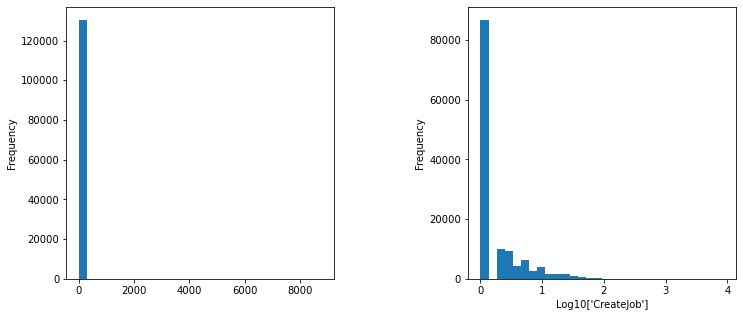

Percentage of zero entries in "CreateJob": 66.47%


In [14]:
# Display statistical information of the feature "CreateJob" (number of jobs created)
print(dfCA["CreateJob"].describe())

# Plot histogram of true vs. log values 
fig, axes = plt.subplots(nrows=1, ncols=2)
plt.rcParams['figure.figsize']=[12,5]
dfCA['CreateJob'].plot(kind='hist', bins=30, ax=axes[0])
plt.xlabel('Number of jobs created')
np.log10(dfCA['CreateJob']+1).plot(kind='hist', bins=30, 
                                   ax=axes[1]).set_xlabel("Log10['CreateJob']")
plt.subplots_adjust(wspace=0.5);
plt.show()

# Print percentage of zero entries
print('Percentage of zero entries in "CreateJob": ' 
      + str("{:.2f}".format((dfCA['CreateJob']==0).mean()*100)) + "%")

The histogram of the logarithmically-scaled values is less skewed and more informative than the histogram of the original values.

CreateJob:
             mean         std
Default                      
0        7.896380  215.569435
1        6.997871  216.336314


CreateJob_log:
             mean      std
Default                   
0        0.240530  0.41796
1        0.219834  0.33545


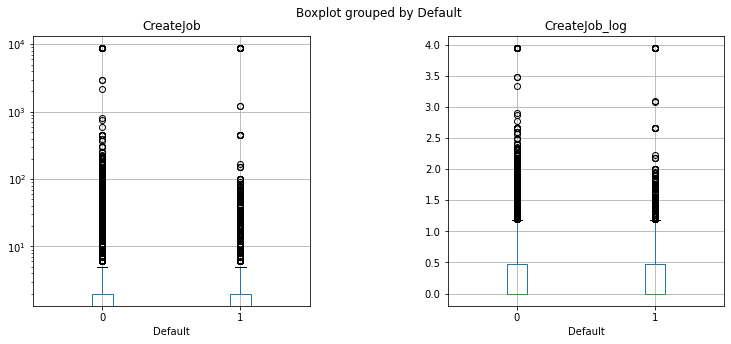

In [16]:
# Boxplot of true vs. log values 
fig, axes = plt.subplots(nrows=1, ncols=2)
plt.rcParams['figure.figsize']=[12,5]
dfCA.boxplot(column=['CreateJob'], by='Default', ax=axes[0]).set_yscale('log')
print("CreateJob:")
print(pd.DataFrame(dfCA.groupby(['Default'])['CreateJob'].describe().loc[:,['mean','std']]))
print("\n")

dfCA = dfCA.assign(CreateJob_log=pd.Series(np.log10(dfCA['CreateJob'] + 1)))
dfCA.boxplot(column=['CreateJob_log'], by='Default', ax=axes[1])
plt.subplots_adjust(wspace=0.5);
print("CreateJob_log:")
print(pd.DataFrame(dfCA.groupby(['Default'])\
                   ['CreateJob_log'].describe().loc[:,['mean','std']]))

Since the distribution of the logarithmically-scaled values of "CreateJob" is not similar to a Gaussian distribution, a Mann-Whitney U test can be used as a statistical test to see how siginificant is the difference in the distributions of default and non-default classes. As shown below, the distributions of default and non-default classes for the features "CreateJob" and "CreateJob_log" are different.

In [17]:
# Perform a statistical test
a = dfCA[dfCA['Default']==0].CreateJob
a_log = dfCA[dfCA['Default']==0].CreateJob_log
b = dfCA[dfCA['Default']==1].CreateJob
b_log = dfCA[dfCA['Default']==1].CreateJob_log
list_a = [a, a_log]
list_b = [b, b_log]
list_label = ["True value data", "Log value data"]
alpha = 0.05

for data1, data2, label in zip(list_a, list_b, list_label):
    stat, p = mannwhitneyu(data1, data2)
    print('%s: stat=%.3f, p=%.3f' %(label, stat, p))
    if p > alpha:
        print('Same distributions (fail to reject H0)\n')
    else:
        print('Different distributions (reject H0)\n')

True value data: stat=1266635907.500, p=0.000
Different distributions (reject H0)

Log value data: stat=1266635907.500, p=0.000
Different distributions (reject H0)



**Feature: RetainedJob**

count    130475.000000
mean         11.116367
std         217.365729
min           0.000000
25%           0.000000
50%           1.000000
75%           5.000000
max        8800.000000
Name: RetainedJob, dtype: float64


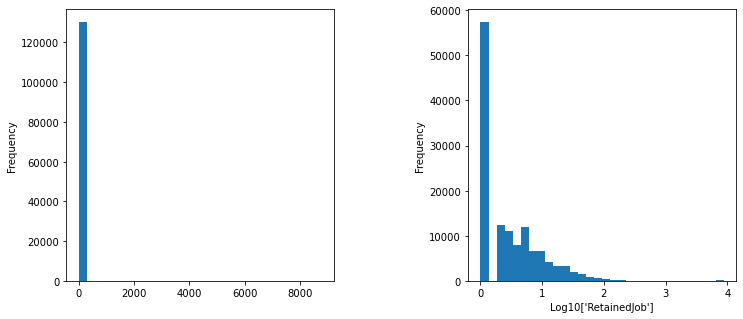

Percentage of zero entries in "RetainedJob": 43.99%


In [19]:
# Display statistical information of the feature "RetainedJob" (number of jobs retained)
print(dfCA["RetainedJob"].describe())

# Plot histogram of true vs. log values 
fig, axes = plt.subplots(nrows=1, ncols=2)
plt.rcParams['figure.figsize']=[12,5]
dfCA['RetainedJob'].plot(kind='hist', bins=30, ax=axes[0])
plt.xlabel('Number of jobs retained')
np.log10(dfCA['RetainedJob']+1).plot(kind='hist', bins=30, 
                                     ax=axes[1]).set_xlabel("Log10['RetainedJob']")
plt.subplots_adjust(wspace=0.5);
plt.show()

# Print percentage of zero entries
print('Percentage of zero entries in "RetainedJob": ' 
      + str("{:.2f}".format((dfCA['RetainedJob']==0).mean()*100)) + "%")

RetainedJob:
              mean         std
Default                       
0        11.333895  217.674195
1        10.193919  216.054675


RetainedJob_log:
             mean       std
Default                    
0        0.420405  0.524825
1        0.561582  0.400903


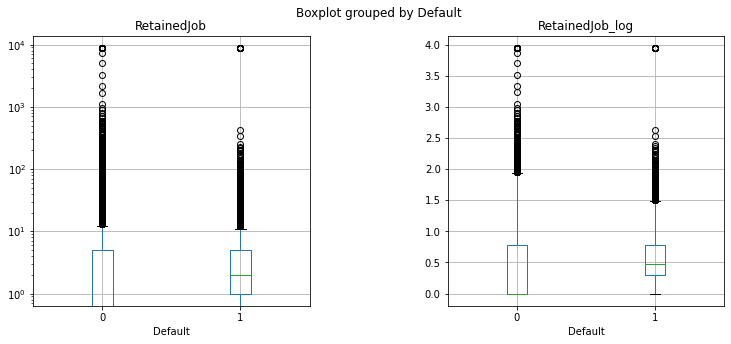

In [21]:
# Boxplot of true vs. log values 
fig, axes = plt.subplots(nrows=1, ncols=2)
plt.rcParams['figure.figsize']=[12,5]
dfCA.boxplot(column=['RetainedJob'], by='Default', ax=axes[0]).set_yscale('log')
print("RetainedJob:")
print(pd.DataFrame(dfCA.groupby(['Default'])['RetainedJob'].describe().loc[:,['mean','std']]))
print("\n")

dfCA = dfCA.assign(RetainedJob_log=pd.Series(np.log10(dfCA['RetainedJob'] + 1)))
dfCA.boxplot(column=['RetainedJob_log'], by='Default', ax=axes[1])
plt.subplots_adjust(wspace=0.5);
print("RetainedJob_log:")
print(pd.DataFrame(dfCA.groupby(['Default'])\
                   ['RetainedJob_log'].describe().loc[:,['mean','std']]))

Since the distribution of the logarithmically-scaled values of "RetainedJob" is not similar to a Gaussian distribution, a Mann-Whitney U test is used as a statistical test to see how siginificant is the difference in the distributions of default and non-default classes. As shown below, the distributions of default and non-default classes for the features "RetainedJob" and "RetainedJob_log" are different.

In [22]:
# Perform a statistical test
a = dfCA[dfCA['Default']==0].RetainedJob
a_log = dfCA[dfCA['Default']==0].RetainedJob_log
b = dfCA[dfCA['Default']==1].RetainedJob
b_log = dfCA[dfCA['Default']==1].RetainedJob_log
list_a = [a, a_log]
list_b = [b, b_log]
list_label = ["True value data", "Log value data"]
alpha = 0.05

for data1, data2, label in zip(list_a, list_b, list_label):
    stat, p = mannwhitneyu(data1, data2)
    print('%s: stat=%.3f, p=%.3f' %(label, stat, p))
    if p > alpha:
        print('Same distributions (fail to reject H0)\n')
    else:
        print('Different distributions (reject H0)\n')

True value data: stat=999074665.000, p=0.000
Different distributions (reject H0)

Log value data: stat=999074665.000, p=0.000
Different distributions (reject H0)



**Feature: NoEmp**

count    130475.000000
mean         13.342180
std          72.691541
min           0.000000
25%           2.000000
50%           5.000000
75%          12.000000
max        9945.000000
Name: NoEmp, dtype: float64


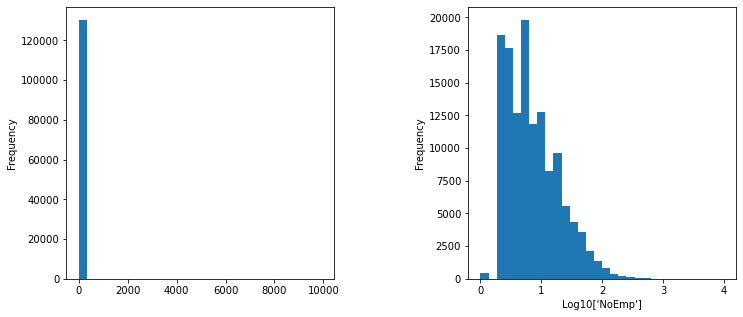

Percentage of zero entries in "NoEmp": 0.34%
Number of entries > 1000: 40


In [24]:
# Display statistical information of the feature "NoEmp" (number of business employees)
print(dfCA["NoEmp"].describe())

# Plot histogram of true vs. log values 
fig, axes = plt.subplots(nrows=1, ncols=2)
plt.rcParams['figure.figsize']=[12,5]
dfCA['NoEmp'].plot(kind='hist', bins=30, ax=axes[0])
plt.xlabel('Number of employees')
np.log10(dfCA['NoEmp']+1).plot(kind='hist', bins=30, ax=axes[1]).set_xlabel("Log10['NoEmp']")
plt.subplots_adjust(wspace=0.5);
plt.show()

# Print percentage of zero entries
print('Percentage of zero entries in "NoEmp": ' 
      + str(((dfCA['NoEmp']==0).mean()*100).round(2)) + "%")
print('Number of entries > 1000: ' + str((dfCA['NoEmp']>1000).sum()))

NoEmp:
              mean        std
Default                      
0        14.770018  69.531746
1         7.287304  84.526498


NoEmp_log:
             mean       std
Default                    
0        0.894784  0.445330
1        0.680615  0.352191


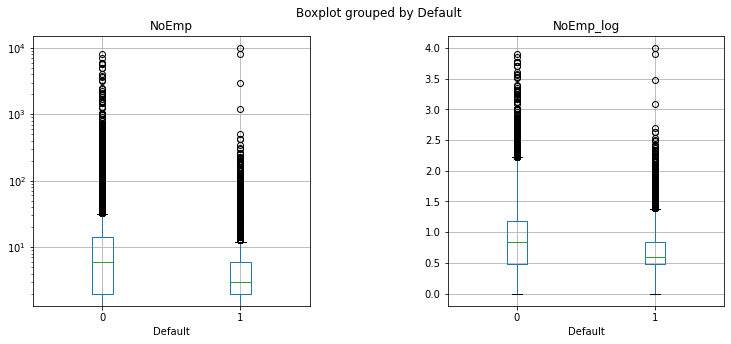

In [26]:
# Boxplot of true vs. log values 
fig, axes = plt.subplots(nrows=1, ncols=2)
plt.rcParams['figure.figsize']=[12,5]
dfCA.boxplot(column=['NoEmp'], by='Default', ax=axes[0]).set_yscale('log')
print("NoEmp:")
print(pd.DataFrame(dfCA.groupby(['Default'])['NoEmp'].describe().loc[:,['mean','std']]))
print("\n")

dfCA = dfCA.assign(NoEmp_log=pd.Series(np.log10(dfCA['NoEmp'] + 1)))
dfCA.boxplot(column=['NoEmp_log'], by='Default', ax=axes[1])
plt.subplots_adjust(wspace=0.5);
print("NoEmp_log:")
print(pd.DataFrame(dfCA.groupby(['Default'])['NoEmp_log'].describe().loc[:,['mean','std']]))

Since the distribution of the logarithmically-scaled values of "NoEmp" is not similar to a Gaussian distribution, a Mann-Whitney U test is used as a statistical test to see how siginificant is the difference in the distributions of default and non-default classes. As shown below, the distributions of default and non-default classes for the features "NoEmp" and "NoEmp_log" are different.

In [27]:
# Perform a statistical test
a = dfCA[dfCA['Default']==0].NoEmp
a_log = dfCA[dfCA['Default']==0].NoEmp_log
b = dfCA[dfCA['Default']==1].NoEmp
b_log = dfCA[dfCA['Default']==1].NoEmp_log
list_a = [a, a_log]
list_b = [b, b_log]
list_label = ["True value data", "Log value data"]
alpha = 0.05

for data1, data2, label in zip(list_a, list_b, list_label):
    stat, p = mannwhitneyu(data1, data2)
    print('%s: stat=%.3f, p=%.3f' %(label, stat, p))
    if p > alpha:
        print('Same distributions (fail to reject H0)\n')
    else:
        print('Different distributions (reject H0)\n')

True value data: stat=939039938.500, p=0.000
Different distributions (reject H0)

Log value data: stat=939039938.500, p=0.000
Different distributions (reject H0)



**Feature: DisbursementGross**

count    1.304750e+05
mean     2.695557e+05
std      3.385755e+05
min      2.527000e+03
25%      5.000000e+04
50%      1.440000e+05
75%      3.520000e+05
max      5.000000e+06
Name: DisbursementGross, dtype: float64


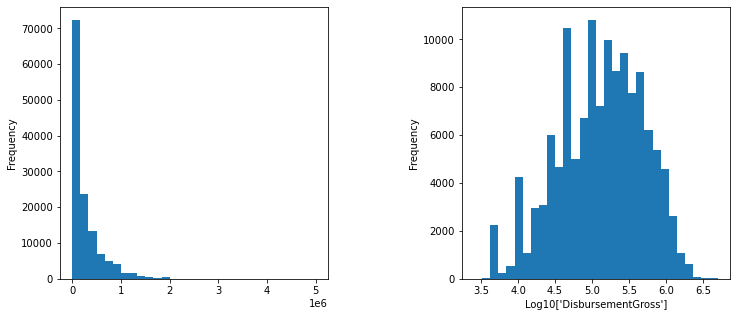

Percentage of zero entries in "DisbursementGross": 0.0%


In [29]:
# Display statistical information of the feature "DisbursementGross" (amount disbursed)
print(dfCA["DisbursementGross"].describe())

# Plot histogram of true vs. log values 
fig, axes = plt.subplots(nrows=1, ncols=2)
plt.rcParams['figure.figsize']=[12,5]
dfCA['DisbursementGross'].plot(kind='hist', bins=30, ax=axes[0])
plt.xlabel('Gross disbursement')
np.log10(dfCA['DisbursementGross']+1).plot(kind='hist', bins=30,
                                           ax=axes[1]).set_xlabel("Log10['DisbursementGross']")
plt.subplots_adjust(wspace=0.5);
plt.show()

# Print percentage of zero entries
print('Percentage of zero entries in "DisbursementGross": ' 
      + str(((dfCA['DisbursementGross']==0).mean()*100).round(2)) + "%")

DisbursementGross:
                  mean            std
Default                              
0        304155.428271  353038.918126
1        122832.433024  213570.319691


DG_log:
             mean       std
Default                    
0        5.197681  0.551702
1        4.746261  0.534209


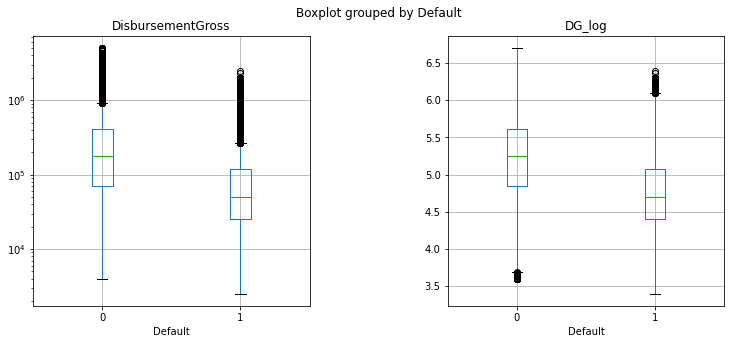

In [31]:
# Boxplot of true vs. log values
fig, axes = plt.subplots(nrows=1, ncols=2)
plt.rcParams['figure.figsize']=[12,5]
dfCA.boxplot(column=['DisbursementGross'], by='Default', ax=axes[0]).set_yscale('log')
print("DisbursementGross:")
print(pd.DataFrame(dfCA.groupby(['Default'])['DisbursementGross'].\
                   describe().loc[:,['mean','std']]))
print("\n")

dfCA = dfCA.assign(DG_log=pd.Series(np.log10(dfCA['DisbursementGross'] + 1)))
dfCA.boxplot(column=['DG_log'], by='Default', ax=axes[1])
plt.subplots_adjust(wspace=0.5);
print("DG_log:")
print(pd.DataFrame(dfCA.groupby(['Default'])['DG_log'].describe().loc[:,['mean','std']]))

Since the distribution of the logarithmically-scaled values of the feature "DisbursementGross" appears to be similar to a Gaussian distribution, a T-test is used as a statistical test to see how siginificant is the difference in the distributions of default and non-default classes. As shown below, the distributions of non-default and default classes are different.

In [32]:
# Perform a statistical test
a = dfCA[dfCA['Default']==0].DisbursementGross
a_log = dfCA[dfCA['Default']==0].DG_log
b = dfCA[dfCA['Default']==1].DisbursementGross
b_log = dfCA[dfCA['Default']==1].DG_log
list_a = [a, a_log]
list_b = [b, b_log]
list_label = ["True value data", "Log value data"]
alpha = 0.05

for data1, data2, label in zip(list_a, list_b, list_label):
    stat, p = ttest_ind(data1, data2)
    print('%s: stat=%.3f, p=%.3f' %(label, stat, p))
    if p > alpha:
        print('Same distributions (fail to reject H0)\n')
    else:
        print('Different distributions (reject H0)\n')

True value data: stat=77.755, p=0.000
Different distributions (reject H0)

Log value data: stat=116.835, p=0.000
Different distributions (reject H0)



**Feature: GrAppv**

count    1.304750e+05
mean     2.639147e+05
std      3.409005e+05
min      2.000000e+03
25%      5.000000e+04
50%      1.300000e+05
75%      3.500000e+05
max      5.000000e+06
Name: GrAppv, dtype: float64


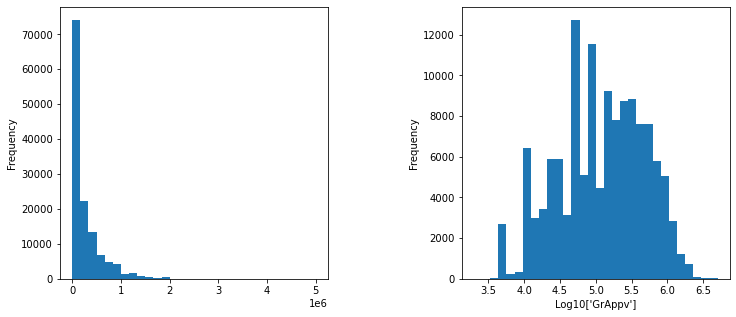

Percentage of zero entries in "GrAppv": 0.0%


In [34]:
# Display statistical information of the feature "GrAppv"
# (Gross amount of loan approved by bank)
print(dfCA["GrAppv"].describe())

# Plot histogram of true vs. log values 
fig, axes = plt.subplots(nrows=1, ncols=2)
plt.rcParams['figure.figsize']=[12,5]
dfCA['GrAppv'].plot(kind='hist', bins=30, ax=axes[0])
plt.xlabel('Gross amount approved by bank')
np.log10(dfCA['GrAppv']+1).plot(kind='hist', bins=30,
                                ax=axes[1]).set_xlabel("Log10['GrAppv']")
plt.subplots_adjust(wspace=0.5);
plt.show()

# Print percentage of zero entries
print('Percentage of zero entries in "GrAppv": ' 
      + str(((dfCA['GrAppv']==0).mean()*100).round(2)) + "%")

GrAppv:
                  mean            std
Default                              
0        300275.621218  354721.269868
1        109722.827770  214626.646780


GrAppv_log:
             mean       std
Default                    
0        5.174073  0.571730
1        4.654493  0.539439


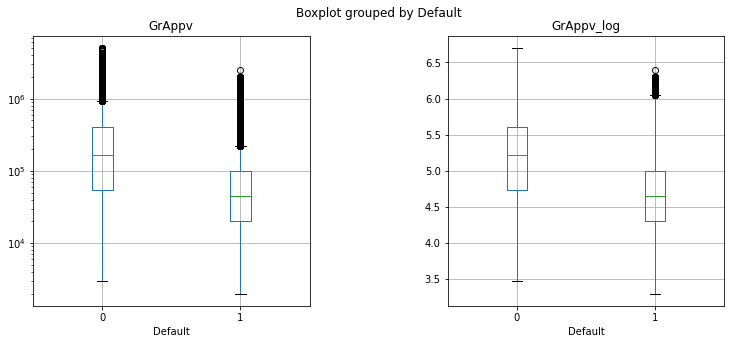

In [36]:
# Boxplot of true vs. log values
fig, axes = plt.subplots(nrows=1, ncols=2)
plt.rcParams['figure.figsize']=[12,5]
dfCA.boxplot(column=['GrAppv'], by='Default', ax=axes[0]).set_yscale('log')
print("GrAppv:")
print(pd.DataFrame(dfCA.groupby(['Default'])['GrAppv'].describe().loc[:,['mean','std']]))
print("\n")

dfCA = dfCA.assign(GrAppv_log=pd.Series(np.log10(dfCA['GrAppv'] + 1)))
dfCA.boxplot(column=['GrAppv_log'], by='Default', ax=axes[1])
plt.subplots_adjust(wspace=0.5);
print("GrAppv_log:")
print(pd.DataFrame(dfCA.groupby(['Default'])['GrAppv_log'].describe().loc[:,['mean','std']]))

Since the distribution of the logarithmically-scaled values of the feature "GrAppv" appears to be similar to a Gaussian distribution, a T-test is used as a statistical test to see how siginificant is the difference in the distributions of default and non-default classes. As shown below, the distributions of non-default and default classes are different.

In [37]:
# Perform a statistical test
a = dfCA[dfCA['Default']==0].GrAppv
a_log = dfCA[dfCA['Default']==0].GrAppv_log
b = dfCA[dfCA['Default']==1].GrAppv
b_log = dfCA[dfCA['Default']==1].GrAppv_log
list_a = [a, a_log]
list_b = [b, b_log]
list_label = ["True value data", "Log value data"]
alpha = 0.05

for data1, data2, label in zip(list_a, list_b, list_label):
    stat, p = ttest_ind(data1, data2)
    print('%s: stat=%.3f, p=%.3f' %(label, stat, p))
    if p > alpha:
        print('Same distributions (fail to reject H0)\n')
    else:
        print('Different distributions (reject H0)\n')

True value data: stat=81.324, p=0.000
Different distributions (reject H0)

Log value data: stat=130.363, p=0.000
Different distributions (reject H0)



**Feature: SBA_Appv**

count    1.304750e+05
mean     2.079906e+05
std      2.783957e+05
min      1.000000e+03
25%      2.500000e+04
50%      1.000000e+05
75%      2.812500e+05
max      5.000000e+06
Name: SBA_Appv, dtype: float64


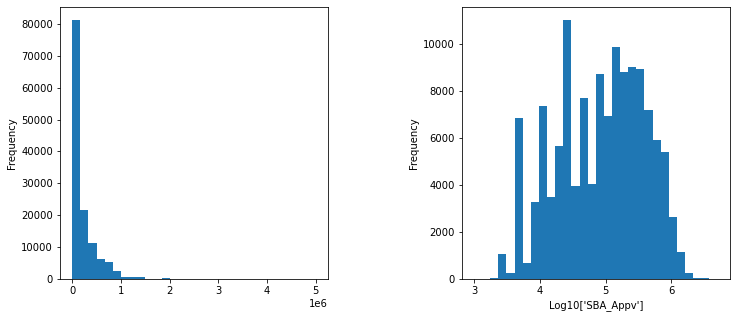

Percentage of zero entries in "SBA_Appv": 0.0%


In [39]:
# Display statistical information of the feature "SBA_Appv"
# (SBA’s guaranteed amount of approved loan)
print(dfCA["SBA_Appv"].describe())

# Plot histogram of true vs. log values 
fig, axes = plt.subplots(nrows=1, ncols=2)
plt.rcParams['figure.figsize']=[12,5]
dfCA['SBA_Appv'].plot(kind='hist', bins=30, ax=axes[0])
plt.xlabel('Amount guaranteed by SBA')
np.log10(dfCA['SBA_Appv']).plot(kind='hist',bins=30,
                                ax=axes[1]).set_xlabel("Log10['SBA_Appv']")
plt.subplots_adjust(wspace=0.5);
plt.show()

# Print percentage of zero entries
print('Percentage of zero entries in "SBA_Appv": ' 
      + str(((dfCA['SBA_Appv']==0).mean()*100).round(2)) + "%")

SBA_Appv:
                  mean            std
Default                              
0        238851.257042  290978.085831
1         77123.304695  161123.355944


SBA_Appv_log:
             mean       std
Default                    
0        5.030920  0.631389
1        4.439511  0.568752


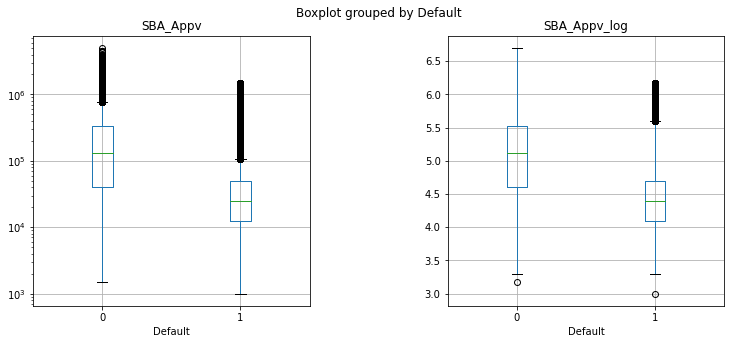

In [41]:
# Boxplot of true vs. log values
fig, axes = plt.subplots(nrows=1, ncols=2)
plt.rcParams['figure.figsize']=[12,5]
dfCA.boxplot(column=['SBA_Appv'], by='Default', ax=axes[0]).set_yscale('log')
print("SBA_Appv:")
print(pd.DataFrame(dfCA.groupby(['Default'])['SBA_Appv'].describe().loc[:,['mean','std']]))
print("\n")

dfCA = dfCA.assign(SBA_Appv_log=pd.Series(np.log10(dfCA['SBA_Appv'] + 1)))
dfCA.boxplot(column=['SBA_Appv_log'], by='Default', ax=axes[1])
plt.subplots_adjust(wspace=0.5);
print("SBA_Appv_log:")
print(pd.DataFrame(dfCA.groupby(['Default'])['SBA_Appv_log'].describe().loc[:,['mean','std']]))

Since the distribution of the logarithmically-scaled values of the feature "SBA_Appv" appears to be similar to a Gaussian distribution, a T-test is used as a statistical test to see how siginificant is the difference in the distributions of default and non-default classes. As shown below, the distributions of non-default and default classes are different.

In [42]:
# Perform a statistical test
a = dfCA[dfCA['Default']==0].SBA_Appv
a_log = dfCA[dfCA['Default']==0].SBA_Appv_log
b = dfCA[dfCA['Default']==1].SBA_Appv
b_log = dfCA[dfCA['Default']==1].SBA_Appv_log
list_a = [a, a_log]
list_b = [b, b_log]
list_label = ["True value data", "Log value data"]
alpha = 0.05

for data1, data2, label in zip(list_a, list_b, list_label):
    stat, p = ttest_ind(data1, data2)
    print('%s: stat=%.3f, p=%.3f' %(label, stat, p))
    if p > alpha:
        print('Same distributions (fail to reject H0)\n')
    else:
        print('Different distributions (reject H0)\n')

True value data: stat=84.691, p=0.000
Different distributions (reject H0)

Log value data: stat=135.408, p=0.000
Different distributions (reject H0)



**Feature: Term**

count    130475.000000
mean        141.755202
std          96.894112
min           0.000000
25%          77.000000
50%          96.000000
75%         240.000000
max         527.000000
Name: Term, dtype: float64


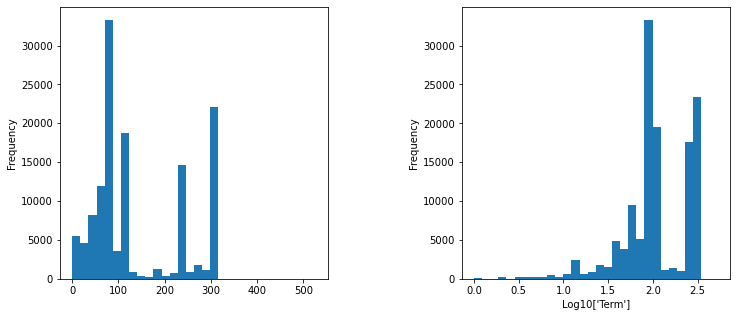

Percentage of zero entries in "Term": 0.08%


In [44]:
# Display statistical information of the "Term" feature (Loan term in months)
print(dfCA["Term"].describe())

# Plot histogram of true vs. log values 
fig, axes = plt.subplots(nrows=1, ncols=2)
plt.rcParams['figure.figsize']=[12,5]
dfCA['Term'].plot(kind='hist', bins=30, ax=axes[0])
plt.xlabel('Number of months')
np.log10(dfCA['Term']+1).plot(kind='hist', bins=30, ax=axes[1]).set_xlabel("Log10['Term']")
plt.subplots_adjust(wspace=0.5);
plt.show()

# Print percentage of zero entries
print('Percentage of zero entries in "Term": ' 
      + str(((dfCA['Term']==0).mean()*100).round(2)) + "%")

For this dataset, imputing the zero values for the feature "Term" with simply the mean or median (or any other) value of "Term" would not be the ideal thing to do because the dataset includes information for businesses that cover a wide range in terms of sizes (one employee vs. 1000+ employees), economic sectors, new vs. existing businesses, and urban vs. rural businesses. Since all of these factors play an important role in deciding the loan term for a business, it is challenging to impute the zero values. Therefore, to avoid any major errors, it is best to remove these instances from the dataset.

In [45]:
# Remove rows with zero values for "Term"
dfCA.drop(dfCA[dfCA["Term"]==0].index, inplace=True)
dfCA.shape

(130373, 25)

In [46]:
# Compute number of loan terms greater than [100, 200, 300, 400, 500] months
# Note: [100, 200, 300, 400, 500] months is about [8, 17, 25, 33, 42] years
print("Number of loan terms < 100 months: " + str((dfCA['Term'] < 100).sum()))
print("Number of loan terms in range [100, 200) months: " + 
      str(((dfCA['Term'] >= 100) & (dfCA['Term'] < 200)).sum()))
print("Number of loan terms in range [200, 300) months: " + 
      str(((dfCA['Term'] >= 200) & (dfCA['Term'] < 300)).sum()))
print("Number of loan terms in range [300, 400) months: " + 
      str(((dfCA['Term'] >= 300) & (dfCA['Term'] < 400)).sum()))
print("Number of loan terms in range [400, 500) months: " + 
      str(((dfCA['Term'] >= 400) & (dfCA['Term'] < 500)).sum()))
print("Number of loan terms >= 500 months: " + str((dfCA['Term'] >= 500).sum()))

Number of loan terms < 100 months: 66422
Number of loan terms in range [100, 200) months: 22206
Number of loan terms in range [200, 300) months: 19635
Number of loan terms in range [300, 400) months: 22104
Number of loan terms in range [400, 500) months: 5
Number of loan terms >= 500 months: 1


In [47]:
# Display instances with loan term >= 400 months
dfCA[dfCA["Term"]>=400].T

,48386,61080,66171,71396,118249,122782
LoanNr_ChkDgt,3345513009,4131363000,4456093000,4786884000,8748651010,9095743001
Name,MINO CONSTRUCTION,I-BELLE HAIR SALON (R),"KANGIHNN PAIK, M.D. (R)",PACIFIC SURF PROPERTIES,CHEMICAL PRODUCTS INC,"SEQUOIA CLEANING, INC."
ApprovalDate,30-Nov-88,11-Jun-90,15-May-91,7-Aug-01,29-Sep-78,14-Mar-96
ApprovalFY,1989,1990,1991,2001,1978,1996
Term,481,413,414,527,412,429
NoEmp,5,4,2,6,2,14
NewExist,1,2,1,1,1,1
CreateJob,0,0,0,0,0,0
RetainedJob,0,0,0,0,0,0
UrbanRural,0,0,0,1,0,0


As mentioned in the "StepOne_DataWrangling" notebook and the article cited therein, since the term of the loan is a function of the expected lifetime of the assets, loans backed by real estate will have terms 20 years or greater (>240 months) and are the only loans granted for such a long term. This is because a loan backed by real estate (possession of land) has a lower probability of default, since the value of the land is often large enough to cover the amount of any principal outstanding.

As displayed above, there are 6 instances with a loan term of >= 400 months. While it is possible for some of these businesses, for example, Mino Constructon and Pacific Surf Properties, to have such big loan terms, it is not likely for the others. Since it is uncertain that these values are correct, and given that these instances are outliers in terms of the feature "Term", they are removed from the dataset.

In [48]:
# Remove instances with loan term >= 400 months
dfCA.drop(dfCA[dfCA["Term"]>400].index, inplace=True)

# Check shape of dataframe
dfCA.shape

(130367, 25)

count    130367.000000
mean        141.852110
std          96.830614
min           1.000000
25%          77.000000
50%          96.000000
75%         240.000000
max         385.000000
Name: Term, dtype: float64


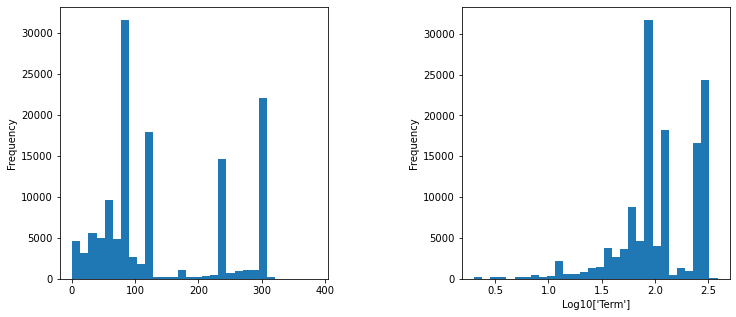

Percentage of zero entries in "Term": 0.0%


In [50]:
# Display statistical information of the feature "Term" (loan term in months)
print(dfCA["Term"].describe())

# Plot histogram of true vs. log values 
fig, axes = plt.subplots(nrows=1, ncols=2)
plt.rcParams['figure.figsize']=[12,5]
dfCA['Term'].plot(kind='hist', bins=30, ax=axes[0])
plt.xlabel('Number of months')
np.log10(dfCA['Term']+1).plot(kind='hist', bins=30, ax=axes[1]).set_xlabel("Log10['Term']")
plt.subplots_adjust(wspace=0.5);
plt.show()

# Print percentage of zero entries
print('Percentage of zero entries in "Term": ' 
      + str(((dfCA['Term']==0).mean()*100).round(2)) + "%")

Term:
               mean        std
Default                       
0        161.761135  95.056969
1         57.092027  44.197580


Term_log:
             mean       std
Default                    
0        2.121713  0.304373
1        1.645960  0.359923


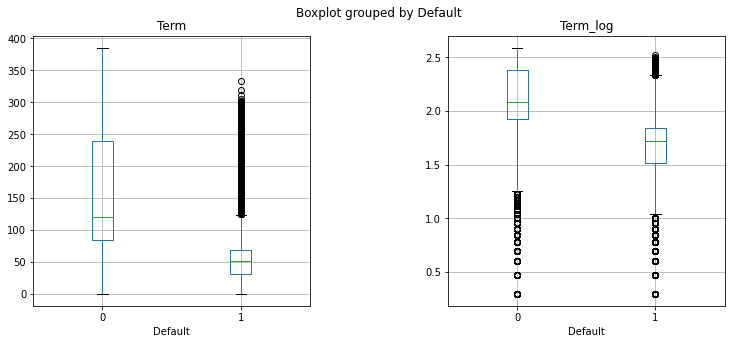

In [52]:
# Boxplot of true vs. log values 
fig, axes = plt.subplots(nrows=1, ncols=2)
plt.rcParams['figure.figsize']=[12,5]
dfCA.boxplot(column=['Term'], by='Default', ax=axes[0])
print("Term:")
print(pd.DataFrame(dfCA.groupby(['Default'])['Term'].describe().loc[:,['mean','std']]))
print("\n")

dfCA = dfCA.assign(Term_log=pd.Series(np.log10(dfCA['Term'] + 1)))
dfCA.boxplot(column=['Term_log'], by='Default', ax=axes[1])
plt.subplots_adjust(wspace=0.5);
print("Term_log:")
print(pd.DataFrame(dfCA.groupby(['Default'])['Term_log'].describe().loc[:,['mean','std']]))

Since the distribution of the original and logarithmically-scaled values of "Term" is not similar to a Gaussian distribution, a Mann-Whitney U test is used as a statistical test to see how siginificant is the difference in the distributions of default and non-default classes. As shown below, the distributions of default and non-default classes for the features "Term" and "Term_log" are different.

In [53]:
# Perform a statistical test
a = dfCA[dfCA['Default']==0].Term
a_log = dfCA[dfCA['Default']==0].Term_log
b = dfCA[dfCA['Default']==1].Term
b_log = dfCA[dfCA['Default']==1].Term_log
list_a = [a, a_log]
list_b = [b, b_log]
list_label = ["True value data", "Log value data"]
alpha = 0.05

for data1, data2, label in zip(list_a, list_b, list_label):
    stat, p = mannwhitneyu(data1, data2)
    print('%s: stat=%.3f, p=%.3f' %(label, stat, p))
    if p > alpha:
        print('Same distributions (fail to reject H0)\n')
    else:
        print('Different distributions (reject H0)\n')

True value data: stat=304524317.500, p=0.000
Different distributions (reject H0)

Log value data: stat=304524317.500, p=0.000
Different distributions (reject H0)



**Feature: NewExist**

In [54]:
# Display statistical information of the feature "NewExist"
# Existing business = 1, New business = 2
print(dfCA["NewExist"].value_counts())

# Print percentage of zero entries
print('Percentage of zero entries in "NewExist": ' + 
      str(((dfCA['NewExist']==0).mean()*100).round(2)) + "%")

1    108737
2     21518
0       112
Name: NewExist, dtype: int64
Percentage of zero entries in "NewExist": 0.09%


For categorical features/variables such as "NewExist", "UrbanRural", and "Sector", the chi-squared test is used as a statistical test for independence between categorical variables, i.e., the test is used to determine whether the output/target variable is dependent or independent of the input variables. If independent, then the input variable may be irrelevant to the problem and may be removed from the dataset.

The null hypothesis of the chi-squared test is that no relationship exists between the categorical variables; they are independent. As shown below, the categorical features "NewExist" and "Default" (the target feature) are probably dependent.

In [55]:
# Create a contingency table for the "NewExist" feature
contingency_ne = pd.crosstab(dfCA["NewExist"], dfCA["Default"])
print("Contingency table:")
display(contingency_ne)

# Perform chi-squared statistical test for "NewExist"
stat, p, dof, expected = chi2_contingency(contingency_ne)
alpha = 0.05
print('stat=%.3f , p=%.3f' %(stat, p))
if p > alpha:
    print('Probably independent \n')
else:
    print('Probably dependent \n')

Contingency table:


Default,0,1
NewExist,,
0,107,5
1,89207,19530
2,16256,5262


stat=507.115 , p=0.000
Probably dependent 



**Feature: UrbanRural**

In [56]:
# Display statistical information of the "UrbanRural" feature
# Undefined = 0, Urban = 1, Rural = 2
print(dfCA["UrbanRural"].value_counts())
print('Percentage of zero entries in "UrbanRural": ' + 
      str(((dfCA['UrbanRural']==0).mean()*100).round(2)) + "%")

1    77324
0    47514
2     5529
Name: UrbanRural, dtype: int64
Percentage of zero entries in "UrbanRural": 36.45%


As shown below, the categorical features "UrbanRural" and "Default" (the target feature) are probably dependent.

In [57]:
# Create a contingency table for the "UrbanRural" feature
contingency_ur = pd.crosstab(dfCA["UrbanRural"], dfCA["Default"])
print("Contingency table:")
display(contingency_ur)

# Perform chi-squared statistical test for "UrbanRural"
stat, p, dof, expected = chi2_contingency(contingency_ur)
alpha = 0.05
print('stat=%.3f , p=%.3f' %(stat, p))
if p > alpha:
    print('Probably independent \n')
else:
    print('Probably dependent \n')

Contingency table:


Default,0,1
UrbanRural,,
0,44841,2673
1,56760,20564
2,3969,1560


stat=8717.941 , p=0.000
Probably dependent 



**Feature: Sector**

The plot below shows the number of loans for each sector. As seen previously, the top five sectors with most instances are: Retail trade (44), Wholesale trade (42), Professional, scientific, and technical services (54), Other services (except public administration) (81), and Accommodation and food services (72). 

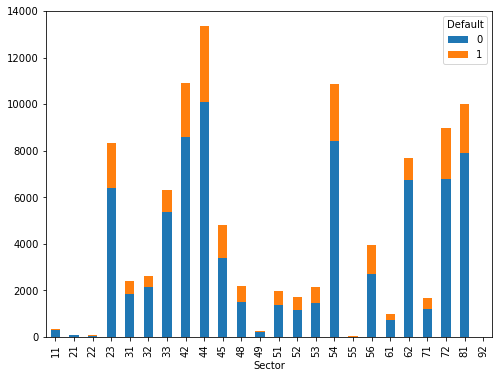

In [59]:
# Plot default values for each sector excluding zero entries for "Sector"
plt.rcParams['figure.figsize']=[8,6]
dfCA.groupby("Sector")["Default"].value_counts().unstack(
    level=-1)[1:].plot(kind="bar",stacked=True);

As shown below, the categorical features "Sector" and "Default" (the target feature) are probably dependent.

In [60]:
# Create a contingency table for the "Sector" feature
contingency_sector = pd.crosstab(dfCA["Sector"], dfCA["Default"])

# Perform chi-squared statistical test for "Sector"
stat, p, dof, expected = chi2_contingency(contingency_sector)
alpha = 0.05
print('stat=%.3f , p=%.3f' %(stat, p))
if p > alpha:
    print('Probably independent \n')
else:
    print('Probably dependent \n')

stat=6070.480 , p=0.000
Probably dependent 



In [61]:
# Create a dataframe for features with remaining zero entries
data_zeros = []
features = ['NoEmp', 'NewExist', 'UrbanRural', 'Sector']
df_zeros_index = ['Number of zeros', 'Default 0', 'Default 1']
df_zeros = pd.DataFrame(data_zeros, columns=features, index=df_zeros_index)

def count_zeros(df, features):
    for feature in features:
        df_zeros.loc['Number of zeros', feature] = (df[feature]==0).sum()
        df_zeros.loc['Default 0', feature] = ((df[feature]==0) & (df['Default']==0)).sum()
        df_zeros.loc['Default 1', feature] = ((df[feature]==0) & (df['Default']==1)).sum()
        
    return df_zeros

count_zeros(dfCA, features)

,NoEmp,NewExist,UrbanRural,Sector
Number of zeros,449,112,47514,28662
Default 0,201,107,44841,27043
Default 1,248,5,2673,1619


Selecting random values or mean/median values to impute zero values is not ideal for the given dataset because of the wide variety in the types of businesses included in the dataset. The zero values for the feature "NoEmp" might be because the business is owned by a single person, and hence number of (additional) employees is zero. The zero values in the categorical features "NewExist", "UrbanRural", and "Sector" can be thought of as another ("undefined") category for each feature. These features shall be dealt with in the notebook "StepThree_Training_Modeling".

In [62]:
# Check shape of dataframe
dfCA.shape

(130367, 26)

### 3.3 Save data<a id='3.3_Save_data'></a>

In [63]:
# Save data for training and modeling
datapath = '../data_models'
if not os.path.exists(datapath):
    os.mkdir(datapath)

datapath_loanapprdata = os.path.join(datapath, 'SBAnational_CA_features.csv')
dfCA.to_csv(datapath_loanapprdata, index=False)

## 4 Summary<a id='4_Summary'></a>

The exploratory data analysis of the dataset helps in analyzing the dataset in more detail. Plotting histograms of the numeric features gives insights into the distributions of each feature, and reveals any (obvious) outliers. A boxplot for the default and non-default classes for each feature shows the range of values of the two classes for that feature. A corresponding statistical test helps in determining how siginificant is the difference in the distributions of default and non-default classes. The statistical tests also help in getting an overview of the more important and less important features.

Logarithmic scaling is used to scale numeric input features that have skewed distributions. The statistical tests show that (probably) all input features - numeric and categorical - are important features in making predictions about whether a loan would be defaulted or paid in full. Some extreme outliers are removed from the feature "Term". This results in a dataset with 130367 instances and 26 features. The additional features are a result of the logarithmic values generated for some of the features. The final clean dataset is saved as "SBAnational_CA_features.csv". The features and their contributions in making predictions using various machine learning models are investigated in the notebook "StepThree_Training_Modeling".